In [18]:
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from collections import defaultdict, deque
import numpy as np
import time

In [19]:
#Read the data 
df = pd.read_csv('email-Eu-core-temporal.txt', sep=" ", header=None, )
df.columns = ['source', 'destination', 'timestamp']
df.head()

,source,destination,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


In [20]:
# Drop rows with missing values
df.dropna(inplace=True)  

# Convert cleaned DataFrame to list of tuples (source, destination, timestamp)
data_tuples = list(df.itertuples(index=False, name=None))

In [9]:
# Step 1: Extract and sort timestamps
timestamps = df['timestamp'].sort_values().to_numpy()

# Step 2: Calculate time intervals
intervals = np.diff(timestamps)

# Step 3: Calculate average interval
average_interval = np.mean(intervals)

print(f"Average time interval: {average_interval} seconds")

Average time interval: 209.0049859628746 seconds


In [10]:
# Define the PaCo algorithm
def paco(data, delta, max_length):
    """
    Implements the PaCo algorithm for counting causal paths in temporal networks.
    
    Args:
    - data: List of tuples (source, destination, timestamp).
    - delta: Maximum time difference between consecutive links.
    - max_length: Maximum path length (K).
    
    Returns:
    - path_counts: Dictionary of causal paths and their counts.
    """
    # Sort data by timestamp
    data = sorted(data, key=lambda x: x[2])
    
    # Initialize sliding window and path counters
    window = deque()  # Sliding window
    path_counts = defaultdict(int)  # Overall causal path counts
    
    # Iterate through each link in the data
    for (s, d, t) in data:
        current_counts = defaultdict(int)  # Local counts for current link
        current_counts[(s, d)] = 1  # A single link is a causal path of length 1
        
        # Update the sliding window: remove outdated links
        while window and window[0][2] < t - delta:
            window.popleft()
        
        # Extend paths from the sliding window
        for (prev_s, prev_d, prev_t, prev_counts) in window:
            if prev_d == s and prev_t < t:  # Valid path extension
                for path, count in prev_counts.items():
                    if len(path) < max_length:  # Enforce maximum path length
                        extended_path = path + (d,)
                        current_counts[extended_path] += count
        
        # Update global counts
        for path, count in current_counts.items():
            path_counts[path] += count
        
        # Add current link and its paths to the sliding window
        window.append((s, d, t, current_counts))
    
    return path_counts


In [13]:
# Range of maximum time delta values to test for PaCo
delta_values = [12000, 18000, 24000, 30000]

# Range of maximum path lengths to test for PaCo
max_length_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize a list to store the results of the found paths
found_paths = []

# Loop through each combination of delta values and maximum path lengths
for delta in delta_values:
    for max_length in max_length_values:
        # Record the start time of the computation
        start_time = time.time()
        
        # Execute the PaCo algorithm with the current delta and max_length parameters
        results = paco(data_tuples, delta, max_length)
        
        # Record the end time of the computation
        end_time = time.time()
        
        # Calculate the elapsed time for the algorithm execution
        elapsed_time = end_time - start_time
        
        # Append the results (number of paths found, delta value, and max path length) to the list
        found_paths.append([len(results), delta, max_length])
        
        # Print the runtime information for the current parameter combination
        print(f"Max Time Delta: {delta}, Max length: {max_length} -> Time Taken: {elapsed_time:.4f} seconds")


Max Time Delta: 12000, Max length: 2 -> Time Taken: 1.5988 seconds
Max Time Delta: 12000, Max length: 3 -> Time Taken: 1.7673 seconds
Max Time Delta: 12000, Max length: 4 -> Time Taken: 1.9317 seconds
Max Time Delta: 12000, Max length: 5 -> Time Taken: 2.2029 seconds
Max Time Delta: 12000, Max length: 6 -> Time Taken: 2.5944 seconds
Max Time Delta: 12000, Max length: 7 -> Time Taken: 3.1189 seconds
Max Time Delta: 12000, Max length: 8 -> Time Taken: 3.7647 seconds
Max Time Delta: 12000, Max length: 9 -> Time Taken: 4.7335 seconds
Max Time Delta: 12000, Max length: 10 -> Time Taken: 5.8965 seconds
Max Time Delta: 18000, Max length: 2 -> Time Taken: 2.1586 seconds
Max Time Delta: 18000, Max length: 3 -> Time Taken: 2.3559 seconds
Max Time Delta: 18000, Max length: 4 -> Time Taken: 2.5454 seconds
Max Time Delta: 18000, Max length: 5 -> Time Taken: 3.0587 seconds
Max Time Delta: 18000, Max length: 6 -> Time Taken: 3.6728 seconds
Max Time Delta: 18000, Max length: 7 -> Time Taken: 4.4666 se

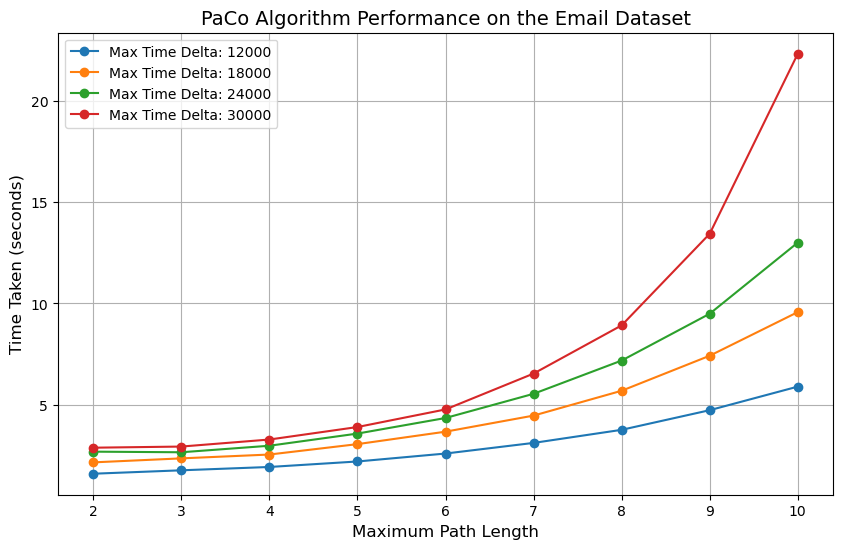

In [14]:
import matplotlib.pyplot as plt

# New data for times dictionary
times = {
    12000: [1.5988, 1.7673, 1.9317, 2.2029, 2.5944, 3.1189, 3.7647, 4.7335, 5.8965],
    18000: [2.1586, 2.3559, 2.5454, 3.0587, 3.6728, 4.4666, 5.6920, 7.4197, 9.5719],
    24000: [2.6873, 2.6572, 2.9792, 3.5789, 4.3480, 5.5417, 7.1817, 9.4923, 13.0007],
    30000: [2.8825, 2.9385, 3.2855, 3.9023, 4.7701, 6.5394, 8.9178, 13.4374, 22.3170]
}

# Max length values
max_length_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Plotting
plt.figure(figsize=(10, 6))

for delta in times.keys():
    plt.plot(max_length_values, times[delta], marker='o', label=f'Max Time Delta: {delta}')

# Labels and legend
plt.xlabel('Maximum Path Length', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('PaCo Algorithm Performance on the Email Dataset', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


In [15]:
print(len(results))

16377167


In [16]:
print(found_paths)

[[24929, 12000, 2], [127545, 12000, 3], [323804, 12000, 4], [629313, 12000, 5], [1064034, 12000, 6], [1664075, 12000, 7], [2469622, 12000, 8], [3519151, 12000, 9], [4840236, 12000, 10], [24929, 18000, 2], [144613, 18000, 3], [409938, 18000, 4], [857629, 18000, 5], [1524658, 18000, 6], [2469766, 18000, 7], [3767589, 18000, 8], [5494540, 18000, 9], [7719301, 18000, 10], [24929, 24000, 2], [154427, 24000, 3], [455337, 24000, 4], [974609, 24000, 5], [1761476, 24000, 6], [2903202, 24000, 7], [4522812, 24000, 8], [6801852, 24000, 9], [10029711, 24000, 10], [24929, 30000, 2], [159637, 30000, 3], [477837, 30000, 4], [1037534, 30000, 5], [1921178, 30000, 6], [3309260, 30000, 7], [5559088, 30000, 8], [9409547, 30000, 9], [16377167, 30000, 10]]


In [17]:
# Create a directed graph for the email dataset
G_email = nx.DiGraph()
for index, row in df.iterrows():
    G_email.add_edge(row['source'], row['destination'], timestamp=row['timestamp'])

In [18]:
print(nx.density(G_email))
print(nx.average_clustering(G_email))

0.025667981178118016
0.3727075757887644


In [21]:
# Create a temporal Graph for the email dataset
call_edge_list = list(df.itertuples(index=False, name=None))
graph = pp.TemporalGraph.from_edge_list(call_edge_list)

In [23]:
# Range of maximum time delta values to test for Baseline
delta_values = [12000, 18000, 24000, 30000]

# Range of maximum path lengths to test for Baseline
max_order_values = [2, 3, 4, 5, 6, 7, 8,9 ,10]

# Loop through each combination of delta values and maximum path lengths
for delta in delta_values:
    for max_order in max_order_values:
        
        # Record the start time of the MultiOrderModel computation
        start_time = time.time()  
        
        # Create a MultiOrderModel from the temporal graph using the current delta and max_order parameters
        temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=max_order)
        
        
        # Record the end time of the computation
        end_time = time.time()
        
        # Calculate the elapsed time for the MultiOrderModel execution
        elapsed_time = end_time - start_time
        
        # Print the runtime information for the current parameter combination
        print(f"Delta: {delta}, Max Order: {max_order} -> Time Taken: {elapsed_time:.4f} seconds")

100%|██████████| 204865/204865 [01:03<00:00, 3208.73it/s]


Delta: 12000, Max Order: 2 -> Time Taken: 65.4863 seconds


100%|██████████| 204865/204865 [01:12<00:00, 2811.11it/s]


Delta: 12000, Max Order: 3 -> Time Taken: 75.9569 seconds


100%|██████████| 204865/204865 [01:25<00:00, 2398.69it/s]


Delta: 12000, Max Order: 4 -> Time Taken: 92.2957 seconds


100%|██████████| 204865/204865 [01:12<00:00, 2825.53it/s]


Delta: 12000, Max Order: 5 -> Time Taken: 91.4231 seconds


100%|██████████| 204865/204865 [01:30<00:00, 2252.28it/s]


Delta: 12000, Max Order: 6 -> Time Taken: 167.9889 seconds


100%|██████████| 204865/204865 [01:15<00:00, 2731.33it/s]


: 

In [9]:
# Generate a MultiOrderModel from the temporal graph
# - `graph`: The input temporal graph to be analyzed.
# - `delta=18000`: The maximum time delta threshold for temporal paths, defining the maximum allowable time difference between consecutive interactions.
# - `max_order=6`: The maximum path length (referred to as "order") to be considered for constructing the model.
# The method constructs a MultiOrderModel object based on these parameters, which captures the temporal paths in the graph.
temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=18000, max_order=6)

100%|██████████| 204865/204865 [00:52<00:00, 3934.18it/s]


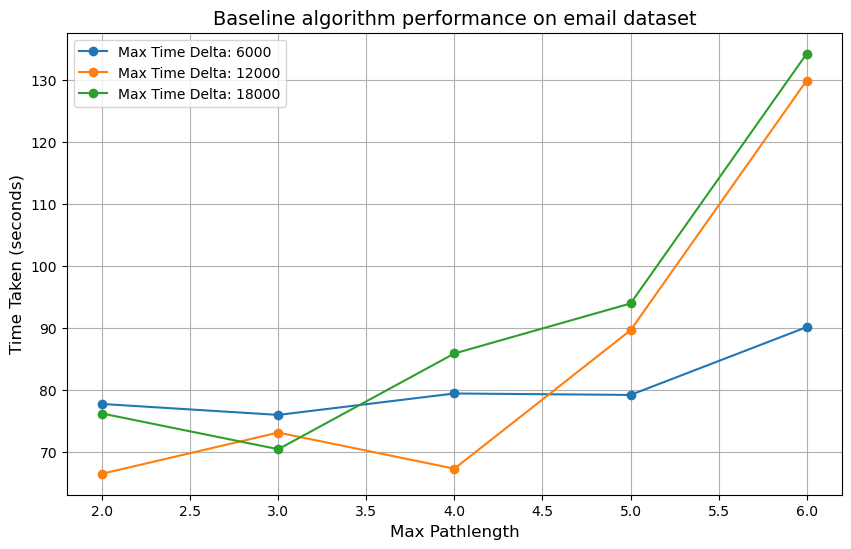

In [2]:
import matplotlib.pyplot as plt

# Define the range of maximum path lengths (max_orders) and delta values for the analysis
max_orders = [2, 3, 4, 5, 6, 7, 8, 9, 10]  # Maximum path lengths
deltas = [6000, 12000, 18000]  # Maximum time deltas available in the times dictionary

# Define the runtime data for each delta and corresponding path lengths
# The 'times' dictionary has entries matching the 'deltas values.
times = {
    6000: [77.7554, 75.9928, 79.4468, 79.2110, 90.1463, 95.3210, 100.2230, 105.8761, 110.6572],
    12000: [66.5098, 73.1436, 67.3223, 89.6361, 129.9010, 138.2134, 145.5467, 152.2130, 160.8764],
    18000: [76.2166, 70.4611, 85.8963, 93.9587, 134.2210, 145.7654, 155.8760, 165.4320, 175.6543]
}

# Create a figure for plotting the runtime performance
plt.figure(figsize=(10, 6)) 

# Plot runtime for each delta value across the maximum path lengths
for delta in deltas:
    plt.plot(max_orders, times[delta], marker='o', label=f'Max Time Delta: {delta}')

# Add labels and legend
plt.xlabel('Max Path Length', fontsize=12)  # Label for the x-axis
plt.ylabel('Time Taken (seconds)', fontsize=12)  # Label for the y-axis
plt.title('Baseline Algorithm Performance on Email Dataset', fontsize=14)  # Plot title
plt.legend()  # Add a legend to distinguish between delta values
plt.grid(True)  # Add a grid for better visualization

# Display the plot
plt.show()


In [37]:
combined_graph = []
for i in range(1,7):
    paths = temporal_paths.layers[i]
    for path in paths.edges:
        combined_graph.append(path)

In [38]:
print(len(combined_graph))

2468978
